# Media Mix Modeling 


## Key Objectives
Companies spend significant budgets on different media such as TV, online, social, print etc. to promote sales of their products and services. In order to optimize these spends and ensure that they give the best impetus to sales, it is important to understand the impact of each media on sales. 

* Create a media mix model to extract the impact of different media on a company's sales. 
* Calculate the Return on Ad Spend for each media.


## Model

The model built here is based on two important and well documented effects of advertising:

**Carryover**: Advertising can have an impact not just in the immediate advertising period (day/week), but in future as well. This results from the fact that many consumers may not immediately act on an advertising they have seen for reasons such as purchase cycles, decision making time, product distribution, inertia etc. The effect that advertising has in future time periods is known as the "carryover" effect of advertising.

**Saturation**: Saturation essentially implies that the impact of any advertising medium will tend to taper and ultimately plateau as more and more money is spent on that medium. Put another way, spending an infinite amount of money on advertising will not lead to infinite sales. 

The model we will create here  can be mathematically represented as:

### &emsp;&emsp; $Y_{t} = Trend_{t} + Media Effect_{t} + \epsilon_{t}$

where 

$Y_{t}$ is the sales in time period (t).

$Trend_{t}$ is the underlying sales trend in time period (t) i.e. sales that takes place without any marketing spend.

$Media Effect_{t}$ is the amount of sales that can be attributed to the media spend. media_effect can be dervied for each medium separately.

$\epsilon_{t}$ is the noise and accounts for the unexplained part of sales.


## Dataset

The dataset used in this project is a synthetic dataset that has around 4 years of weekly data on sales and spends across TV, radio and digital. 




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, norm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
from scipy.signal import convolve2d
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

sns.set_style("whitegrid")
import pickle
import time
import warnings
warnings.filterwarnings('ignore')


### Loading and inspecting the data

In [2]:
mmm_data = pd.read_csv("ad_data.txt")

mmm_data.head()


,Date,TV,radio,digital,sales
0,2018-01-07,13528.1,0.00,0.00,9779.80
1,2018-01-14,0.0,5349.65,2218.93,13245.19
2,2018-01-21,0.0,4235.86,2046.96,12022.66
3,2018-01-28,0.0,3562.21,0.00,8846.95
4,2018-02-04,0.0,0.00,2187.29,9797.07


In [3]:
mmm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     200 non-null    object 
 1   TV       200 non-null    float64
 2   radio    200 non-null    float64
 3   digital  200 non-null    float64
 4   sales    200 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.9+ KB


In [4]:
mmm_data["Date"] = pd.to_datetime(mmm_data["Date"])
mmm_data.set_index("Date", inplace=True)
mmm_data.head()


,TV,radio,digital,sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,9779.80
2018-01-14,0.0,5349.65,2218.93,13245.19
2018-01-21,0.0,4235.86,2046.96,12022.66
2018-01-28,0.0,3562.21,0.00,8846.95
2018-02-04,0.0,0.00,2187.29,9797.07


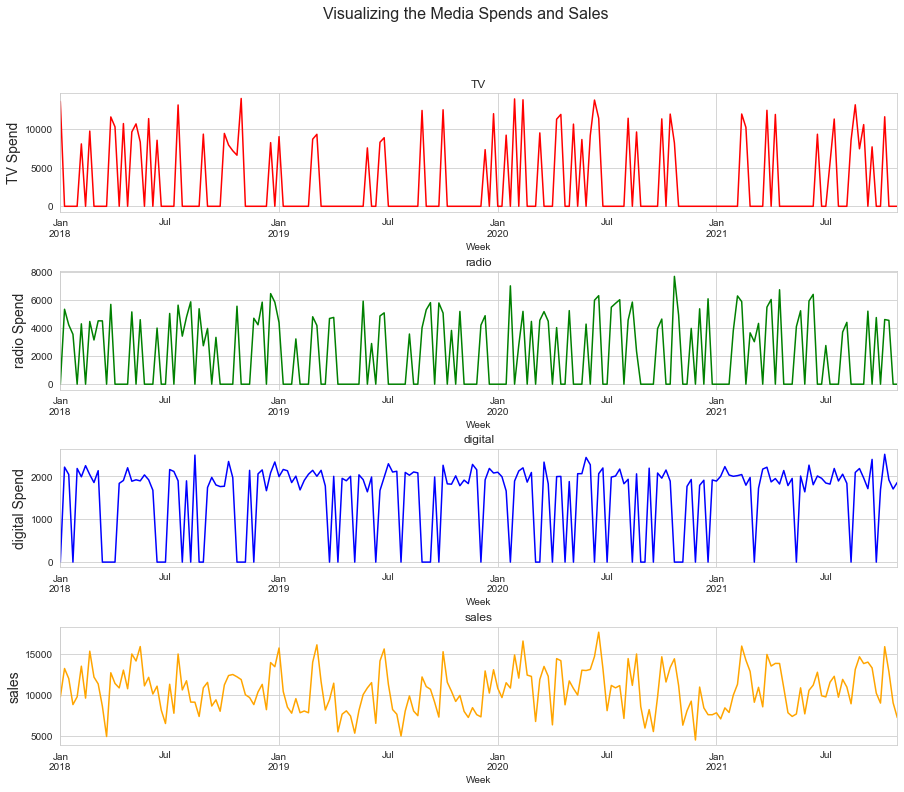

In [5]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(4,1, figsize = (15,12))
colors = {0:'red', 1: 'green', 2: 'blue', 3: 'orange'}
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(4):
    ax = axes.flatten()[i]
    mmm_data[mmm_data.columns[i]].plot(title=mmm_data.columns[i], c = colors[i], ax=ax)
    
    if i < 3:
        ax.set_ylabel(mmm_data.columns[i]+" Spend", fontsize = 14)
    else:
        ax.set_ylabel(mmm_data.columns[i], fontsize = 14)
    ax.set_xlabel("Week")

fig.suptitle("Visualizing the Media Spends and Sales", fontsize = 16)
    
plt.show()

In [6]:
mmm_data = mmm_data.resample("W").asfreq()
mmm_data.resample("Y").sum()


,TV,radio,digital,sales
Date,,,,
2018-12-31,187560.21,126546.76,70454.86,569560.78
2019-12-31,95591.14,92665.35,83925.22,505560.27
2020-12-31,174940.12,126418.46,70708.90,572372.83
2021-12-31,131150.06,97086.44,79055.53,486134.42


**Observations**

1. The sales and ad spend data is available for 200 weeks i.e apprximately 4 years.
2. The TV spends are the highest across each year. They happen infrequently in spurts.
3. Radio spends are more frequent than TV, but lower budget is spent on radio per period as compared to TV.
4. Digital spends are the highest in frequency and the budget spent is the lowest.


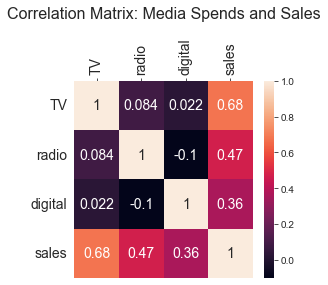

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
ax=sns.heatmap(mmm_data.corr(), annot=True, annot_kws={"size":14})
ax.xaxis.tick_top()
plt.xticks(fontsize="14", rotation=90)
plt.yticks(fontsize="14", rotation=0)
plt.suptitle("Correlation Matrix: Media Spends and Sales", fontsize=16)
plt.tight_layout()
plt.show()


The above shows that sales has a stronger relation with TV spends, with a correlation coefficient of 0.68. Radio and digital have a lower correlation at 0.47 and 0.36 respectively. Let's do some scatter plots to visualize sales with each of the media spends.


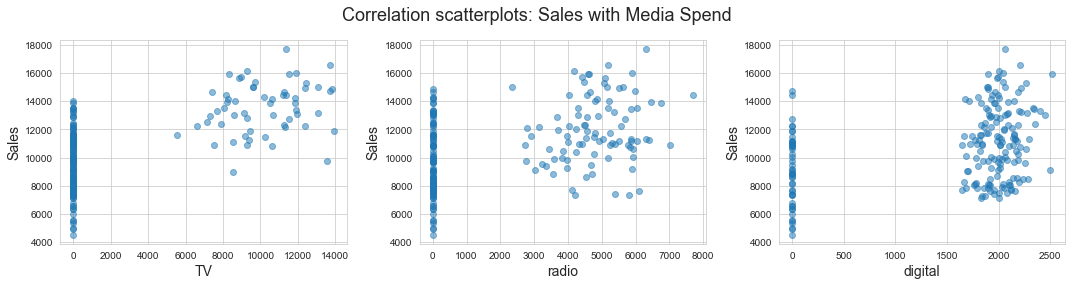

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,4), squeeze=False)
fig.subplots_adjust(wspace=0.5, hspace=0.6)

plt.suptitle("Correlation scatterplots: Sales with Media Spend", fontsize=18)

for i, col in enumerate(list(mmm_data.columns[:3])):
    ax[0][i].scatter(x = col, y = "sales", data=mmm_data, alpha=0.5)
    ax[0][i].set_xlabel(col, fontsize=14)
    ax[0][i].set_ylabel("Sales", fontsize=14)

plt.tight_layout()
plt.show()

    


We notice in the above scatter plots that while Sales has a strong correlation with TV spends, the sales still vary in a broad range as TV spends go up. E.g. At a TV spend of ~12000, the sales vary between 12000 and 18000, that's a 1.5x variation! 

Before modeling sales as a function of media spends, let's check if there is any multi-colinearity between different media spends. 


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(mmm_data.values, i) for i in range(3)]
vif["features"] = mmm_data.columns[:3]

vif.head()


,VIF_Factor,features
0,2.093843,TV
1,2.595381,radio
2,6.152259,digital


We see that the VIF scores are all below 10, indicating that the multicolinearity between different media spends is not significant. 

Now let's build the model.



## Modeling
 

We start by first defining classes to model the **carryover** and **saturation** effect.

**Carryover**: <br>
We shall model the carryover with the **geometric decay** function. In this function, the carryover is modeled with strength and length parameters. <br> 
* The strength (S) parameter (between 0 and 1) indicates the proportion of the effect of spend that carries forward from one period to the next. <br> 
* The length(L) is the no. of time periods this phenomenon continues. <br>

The cumulative media effect (also called adstock) in a particular period is the weighted average of media spend in the current period (t) and the previous (L-1) periods, and defined with the following formula:

### &emsp;&emsp;&emsp;adstock(t) &emsp; = &emsp; $\frac {\sum\limits_{k=0} ^{L-1} S^ {k} X_{t-k}}{\sum\limits_{k=0} ^{L-1} S^ {k}} $

where $X_{t-k}$ is the media spend in period (t-k).

**Saturation**: <br>
There are many functions to model saturation. We shall model the it with the **Hill function**.  The Hill function takes values ranging from 0 to 1 and is characterized by two parameters - K and S. <br>
* K (greater than 0) is the half saturation point and 
* S (again greater than 0) is the slope. 

The Hill function is defined by the following equation:

### &emsp;&emsp;&emsp;Hill(t) &emsp; = &emsp; $\frac {1}{1 + (X_{t}/K)^ {-S}} $

where $X_{t}$ is the media spend in period (t).

As can be seen from the equation above, at $X_{t} = K $, the Hill function equals 0.5, as such K is referred as half saturation point. 

In [10]:

class GeometricDecayCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1) / np.sum(self.strength ** np.arange(self.length + 1))
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

class HillSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, k=1000., s = 2.):
        self.k = k
        self.s = s
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) 
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) 
        return 1 / (1 + (X/self.k)**(-self.s)) 
    

**Transforming the Media Spends and creating the Model**<br>

Having created the classes for the carryover and saturation effects, we now create a **transformer**. The transformer takes the array of each media spend separately and transforms it using the carryover and saturation functions. These functions are combined into a pipeline. By creating the transformer in this fashion, we can optimize the carryover & saturation parameters for each media separately later on.

The **Model** is built as a pipeline containing the transformation and linear regression steps.


In [11]:

adstock = ColumnTransformer(
    [
     ('tv_pipe', Pipeline([
                           ('carryover', GeometricDecayCarryover()),
                           ('saturation', HillSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
                           ('carryover', GeometricDecayCarryover()),
                           ('saturation', HillSaturation())
     ]), ['radio']),
     ('digital_pipe', Pipeline([
                           ('carryover', GeometricDecayCarryover()),
                           ('saturation', HillSaturation())
     ]), ['digital']),
    ],
    remainder='passthrough'
)

MediaMixModel = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])


In [12]:
X = mmm_data.drop(columns=['sales'])
y = mmm_data['sales']

X.head()

,TV,radio,digital
Date,,,
2018-01-07,13528.1,0.00,0.00
2018-01-14,0.0,5349.65,2218.93
2018-01-21,0.0,4235.86,2046.96
2018-01-28,0.0,3562.21,0.00
2018-02-04,0.0,0.00,2187.29


In [13]:

MediaMixModel.fit(X, y)

print(cross_val_score(MediaMixModel, X, y, cv=TimeSeriesSplit()).mean())


0.7309747872262535


The $r^{2}$ score for the model is **0.73**. This is a decent start, as we have not optimized the parameters yet. 

To optimize the parameters, we use the OptunaSearchCV optimizer. We create a dictionary called *param_distributions* to specify the ranges for each parameter.  We then specify 1000 trials and do 5 fold cross-validation using the TimeSeriesSplit() function. As we are dealing with time-series data, this function creates successive iterations of training and holdout set, where the holdout set contains the observations that follow (in time) the training set observations.


In [14]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution


tuned_model = OptunaSearchCV(
    estimator=MediaMixModel,
    param_distributions={
        'adstock__tv_pipe__carryover__strength': FloatDistribution(0.0, 1.0),
        'adstock__tv_pipe__carryover__length': IntDistribution(0, 12),
        'adstock__tv_pipe__saturation__k': FloatDistribution(0.1, 50000),
        'adstock__tv_pipe__saturation__s': FloatDistribution(0.001, 10.0),
        'adstock__radio_pipe__carryover__strength': FloatDistribution(0.0, 1.0),
        'adstock__radio_pipe__carryover__length': IntDistribution(0, 12),
        'adstock__radio_pipe__saturation__k': FloatDistribution(0.1, 50000),
        'adstock__radio_pipe__saturation__s': FloatDistribution(0.001, 10.0),
        'adstock__digital_pipe__carryover__strength': FloatDistribution(0.0, 1.0),
        'adstock__digital_pipe__carryover__length': IntDistribution(0, 12),
        'adstock__digital_pipe__saturation__k': FloatDistribution(0.1, 50000),
        'adstock__digital_pipe__saturation__s': FloatDistribution(0.001, 10.0),
    },
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=5456
)



In [18]:

#print("r-squared scores from model cross-validation:", cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()))


In [17]:
np.mean([0.8285449,  0.9240227,  0.9268381,  0.95783217, 0.94160557])


0.915768688

After optimizing the hyperparameters, we get a mean $r^{2}$ score of **0.916**. This is a significant improvement over the baseline model. 

Let's refit the data to the tuned_model to get the best parameter values. 


In [42]:
tuned_model.fit(X, y)


In [20]:
print(tuned_model.best_params_)

{'adstock__tv_pipe__carryover__strength': 0.5235223178904778, 'adstock__tv_pipe__carryover__length': 12, 'adstock__tv_pipe__saturation__k': 6763.239476294562, 'adstock__tv_pipe__saturation__s': 1.4546221863507545, 'adstock__radio_pipe__carryover__strength': 0.18266879842149092, 'adstock__radio_pipe__carryover__length': 7, 'adstock__radio_pipe__saturation__k': 32990.51597325456, 'adstock__radio_pipe__saturation__s': 0.8153419706883793, 'adstock__digital_pipe__carryover__strength': 0.00023736912413122035, 'adstock__digital_pipe__carryover__length': 8, 'adstock__digital_pipe__saturation__k': 19253.116785489485, 'adstock__digital_pipe__saturation__s': 1.1458357513114636}


In [21]:
print(tuned_model.best_estimator_.named_steps['regression'].coef_)


[10267.92907039 18281.85175045 36508.61399407]


In [22]:
print(tuned_model.best_estimator_.named_steps['regression'].intercept_)


4951.015669502191


In [23]:
with open("mmm_model.pkl", "wb") as f:
    pickle.dump(tuned_model, f)
    

## Visualizing the Carryover and Saturation effect for each media

In [24]:
tv_carryover_strength = 0.5235
tv_carryover_length = 12
radio_carryover_strength =  0.1827
radio_carryover_length = 7
digital_carryover_strength = 0.000237
digital_carryover_length = 8

carryover = pd.DataFrame({'Weeks': np.arange(10)})
tv_denominator = np.sum([(tv_carryover_strength ** i) for i in range(tv_carryover_length+1)])
carryover["TV"] = [(tv_carryover_strength ** i) / tv_denominator \
                          if i <= tv_carryover_length else 0 for i in range(10) ]

radio_denominator = np.sum([(radio_carryover_strength ** i) for i in range(radio_carryover_length+1)])
carryover["Radio"] = [(radio_carryover_strength ** i) / radio_denominator \
                             if i<= radio_carryover_length else 0 for i in range(10) ]

digital_denominator = np.sum([(digital_carryover_strength ** i) for i in range(digital_carryover_length+1)])
carryover["Digital"] = [(digital_carryover_strength ** i) / digital_denominator \
                                 if i <= digital_carryover_length else 0 for i in range(10) ]



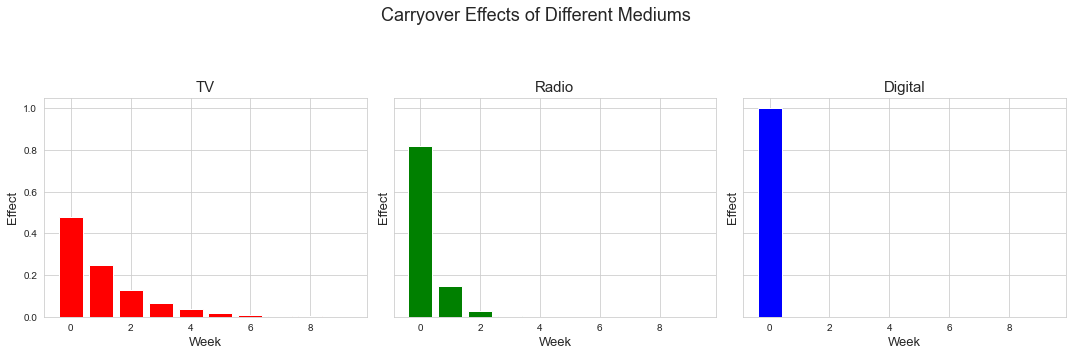

In [25]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey = True)
colors = {0:'red', 1: 'green', 2: 'blue', 3: 'orange'}
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in np.arange(3):
    ax = axes.flatten()[i]
    ax.bar(carryover["Weeks"], carryover.iloc[:,i+1], color = colors[i])
    ax.set_title(carryover.columns[i+1], fontsize=15)
    ax.set_xlabel("Week", fontsize=13)
    ax.set_ylabel("Effect", fontsize=13)

fig.suptitle("Carryover Effects of Different Mediums\n\n", fontsize=18)
plt.tight_layout()
plt.show()

**Observations on carryover effect**<br>

**TV**: TV carryover has a strength of **S = 0.52** and length of **L = 12**. We see from the red bars that about 50% of the effect is in the week of spend and it successively halves in each time period. By the 7th time period though, the effect is very small. <br>

**Radio**: Radio carryover has a strength of **S = 0.18** and length of **L = 7**. We see from the green bars that almost 80% of the radio effect is in the week of spend and it declines very fast. There is hardly any effect after the 4th time period.<br>

**Digital**: Digital carryover strength is negligible at **S = 0.000237** and length of **L = 8**. We see from the blue bars that digital's effect is entirely in the week of spend. <br>


In [26]:
tv_saturation_k = 6763
tv_saturation_s = 1.4546
radio_saturation_k =  32991
radio_saturation_s = 0.8153
digital_saturation_k = 19253
digital_saturation_s = 1.1458

saturation = pd.DataFrame({'Spend': [i*1000 for i in np.arange(60)]})
saturation["TV"] = [0 if i==0 else (1 / (1 + (i*1000/tv_saturation_k)**(-tv_saturation_s))) for i in range(60) ]
saturation["Radio"] = [0 if i==0 else (1 / (1 + (i*1000/radio_saturation_k)**(-radio_saturation_s))) for i in range(60) ]
saturation["Digital"] = [0 if i==0 else (1 / (1 + (i*1000/digital_saturation_k)**(-digital_saturation_s))) for i in range(60) ]



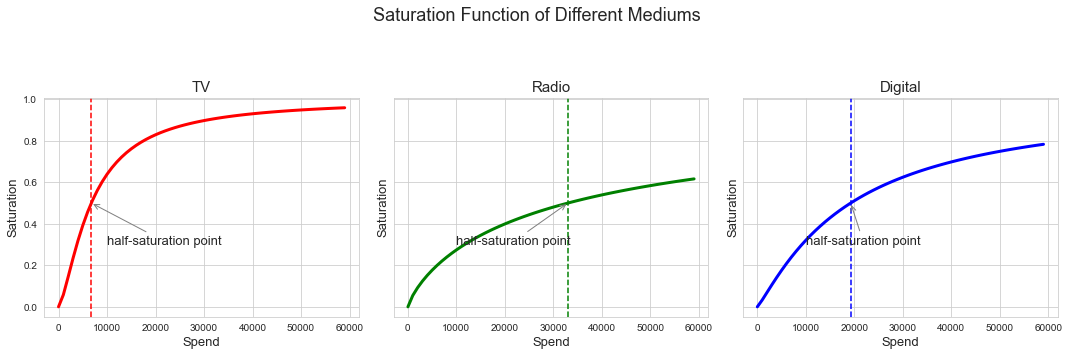

In [28]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharey = True)
colors = {0:'red', 1: 'green', 2: 'blue', 3: 'orange'}
half_saturation = {0: tv_saturation_k, 1: radio_saturation_k, 2: digital_saturation_k}
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i in np.arange(3):
    ax = axes.flatten()[i]
    ax.plot(saturation["Spend"], saturation.iloc[:,i+1], color = colors[i], linewidth=3)
    ax.set_title(saturation.columns[i+1], fontsize=15)
    ax.axvline(half_saturation[i], c = colors[i], linestyle="--")
    ax.annotate('half-saturation point', xy=(half_saturation[i], 0.5), xytext=(10000, 0.3), 
                arrowprops= {"arrowstyle": "->", "color":"gray"}, fontsize=13)
    ax.set_xlabel("Spend", fontsize=13)
    ax.set_ylabel("Saturation", fontsize=13)

fig.suptitle("Saturation Function of Different Mediums\n\n", fontsize=18)
plt.tight_layout()
plt.show()


**Observations on saturation effect**<br>

**TV**: TV saturates the fastest with a half-saturation point **K = 6763** and slope of **S = 1.45**. We see from the red line that TV's effect tapers sharply after a spend of 15,000 and saturates almost completely by 40,000.  <br>

**Radio**: The green line shows the radio saturation curve. Radio saturates slower than TV, with a half-saturation point **K = 32991** and a less steep slope of **S = 0.82**. Radio is not saturated even at 60,000. <br>

**Digital**: Digital saturation is between TV and radio. As we see from the blue line, the digital saturation has a half-saturation point **K = 19250** and a slope of **S = 1.15**. Digital is also not saturated at 60,000.<br>


# Visualizing Prediction vs Actual Sales

We saw earlier that our model has a good performance with a score of $r^{2}$  = **0.916**. Let's plot the predicted sales vs actual sales to see how closely the prediction tracks the actual sales.  

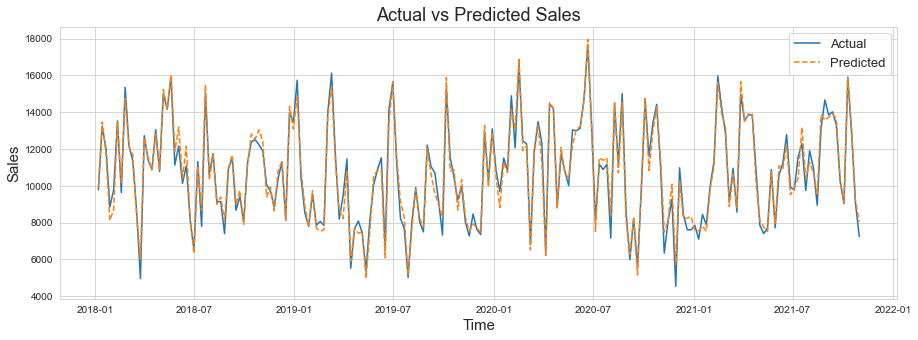

In [29]:
y_pred = tuned_model.predict(X)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X.index, y, label="Actual")
plt.plot(X.index, y_pred, label="Predicted", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.title("Actual vs Predicted Sales", fontsize=18)
plt.legend(fontsize=13)
plt.show()


We see in the above chart that the predictions are pretty close to the actual sales. So the model works.

Let us now find out how well does each media contribute to overall sales. We are interested in calculating the return on Ad spend (**ROAS**) i.e. for every dollar spent on advertising in a particular media, how much does sales go up. 

As each media has carryover and saturation effects, we have to calculate ROAS by reducing the spend in a particular media to 0 for a given time-period and then calculating the change in sales. Both the original sales and the sales after reducing media spend are calculated using the prediction from our model. Also, to isolate the impact of a single media on sales, only spend on one particular media is made 0, keeping spends in other media the same. ROAS can be calculated as follows:

&emsp;&emsp;**ROAS[Media(m)]**&emsp; = &emsp; $\frac {Change in Total Sales} {Amount Spent on Media(m)}$

Given the carryover effect of media, we should expect to see a change not only in the *'change-period'*, but also a few periods after the change. On a similar note, the media spend before the start of change period is likely to have carryover effect during the *'change-period'*. It is therefore a good practice to have the time-periods that are pre and post the *change-period*, to be atleast equal to the carryover length L.


# Return on Ad Spend - TV


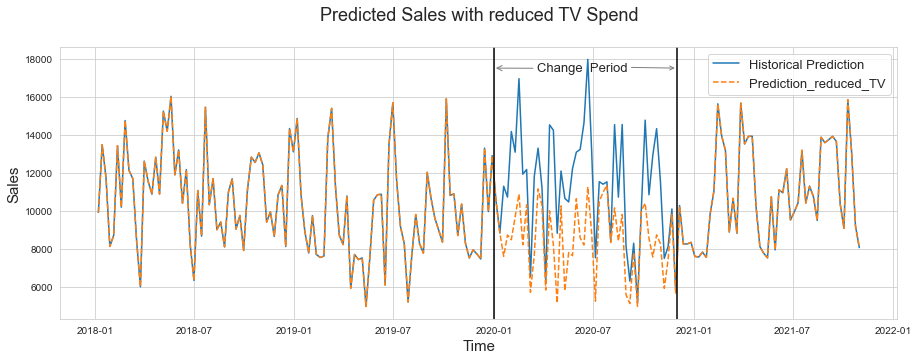

In [35]:
start_date = "2020-01"
end_date = "2020-12"
X_copy = X.copy()
X_copy.loc[start_date : end_date, "TV"] = 0
y_pred_lessTV = tuned_model.predict(X_copy)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X_copy.index, y_pred, label="Historical Prediction")
plt.plot(X_copy.index, y_pred_lessTV, label="Prediction_reduced_TV", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.axvline(pd.Timestamp(start_date), color = 'black')
plt.axvline(pd.Timestamp(end_date), color = 'black')
plt.annotate("Change  Period", xy = (pd.Timestamp(start_date), 17500), xytext=(0.57, 0.91), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"}, fontsize=13)
plt.annotate("", xy = (pd.Timestamp(end_date), 17500), xytext=(0.68, 0.925), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"})
plt.title("Predicted Sales with reduced TV Spend\n", fontsize=18)
plt.legend(fontsize=13)
plt.show()

In [36]:
sales_diff = np.sum(y_pred) - np.sum(y_pred_lessTV)
TV_spend_reduction = np.sum(X[start_date : end_date]["TV"])
roas_TV = sales_diff / TV_spend_reduction
print(f"The Return on Ad Spend for TV is {roas_TV:3.3}")

The Return on Ad Spend for TV is 0.75


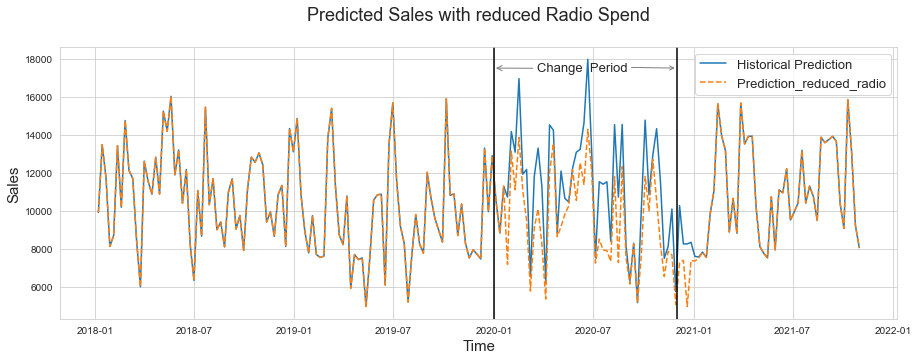

In [37]:
X_copy = X.copy()
X_copy.loc[start_date : end_date, "radio"] = 0
y_pred_less_radio = tuned_model.predict(X_copy)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X_copy.index, y_pred, label="Historical Prediction")
plt.plot(X_copy.index, y_pred_less_radio, label="Prediction_reduced_radio", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.axvline(pd.Timestamp(start_date), color = 'black')
plt.axvline(pd.Timestamp(end_date), color = 'black')
plt.annotate("Change  Period", xy = (pd.Timestamp(start_date), 17500), xytext=(0.57, 0.91), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"}, fontsize=13)
plt.annotate("", xy = (pd.Timestamp(end_date), 17500), xytext=(0.68, 0.925), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"})
plt.title("Predicted Sales with reduced Radio Spend\n", fontsize=18)
plt.legend(fontsize=13)
plt.show()

In [38]:
sales_diff = np.sum(y_pred) - np.sum(y_pred_less_radio)
radio_spend_reduction = np.sum(X[start_date : end_date]["radio"])
roas_radio = sales_diff / radio_spend_reduction

print(f"The Return on Ad Spend for Radio is {roas_radio:3.3}")


The Return on Ad Spend for Radio is 0.707


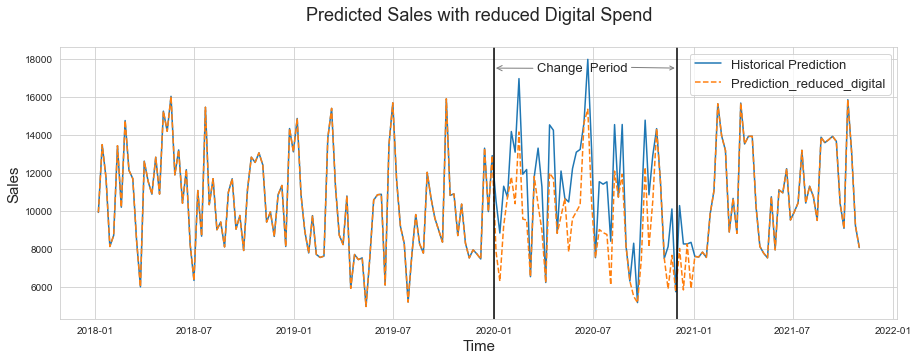

In [39]:
X_copy = X.copy()
X_copy.loc[start_date : end_date, "digital"] = 0
y_pred_less_digital = tuned_model.predict(X_copy)
fig, ax = plt.subplots(1,1, figsize = (15,5))
plt.plot(X_copy.index, y_pred, label="Historical Prediction")
plt.plot(X_copy.index, y_pred_less_digital, label="Prediction_reduced_digital", linestyle="--")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Sales", fontsize=15)
plt.axvline(pd.Timestamp(start_date), color = 'black')
plt.axvline(pd.Timestamp(end_date), color = 'black')
plt.annotate("Change  Period", xy = (pd.Timestamp(start_date), 17500), xytext=(0.57, 0.91), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"}, fontsize=13)
plt.annotate("", xy = (pd.Timestamp(end_date), 17500), xytext=(0.68, 0.925), 
             textcoords = 'axes fraction', arrowprops={"arrowstyle": "->", "color":"gray"})
plt.title("Predicted Sales with reduced Digital Spend\n", fontsize=18)
plt.legend(fontsize=13)
plt.show()

In [41]:
sales_diff = np.sum(y_pred) - np.sum(y_pred_less_digital)
digital_spend_reduction = np.sum(X[start_date : end_date]["digital"])
roas_digital = sales_diff / digital_spend_reduction

print(f"The Return on Ad Spend for Digital is {roas_digital:3.3}")


The Return on Ad Spend for Digital is 1.27


# Conclusion

1. A Linear Regression model based on carryover and saturation effects of advertising was built using the weekly sales data for 4 years.
2. Carryover was modeled by the Geometric Decay function and saturation by the Hill function.
3. The optimized model has good performance with $r^{2}$ = **0.916**. 
4. The optimized parameters for carryover and saturation helped in understanding these characteristics of each media.
5. The model was useful in understanding the Return on Ad Spend (ROAS) for each media as well.
    - Digital has the highest ROAS of **1.27**, followed by TV at **0.75** and finally radio at **0.71**.
